C:\Users\Keertipriya Bellary\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Keertipriya Bellary\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.2899014145037029
Silhouette Score: 0.2330469671130906
Inertia: 474.45025418960245

Cluster Sizes:
Cluster
0    62
2    47
3    46
1    44
Name: count, dtype: int64


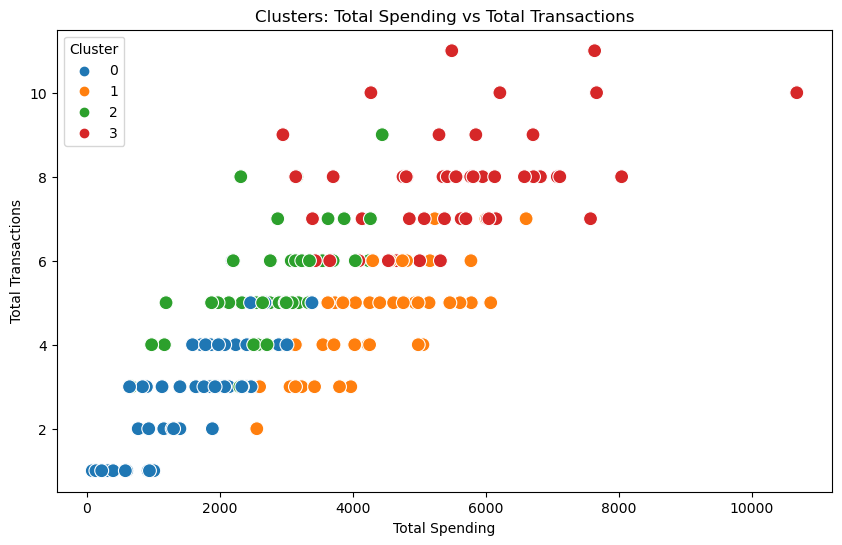

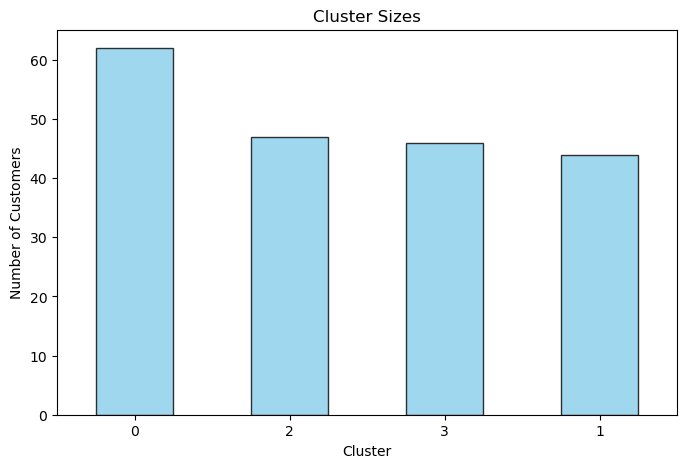

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

transactions_path = r"C:\Users\Keertipriya Bellary\Transactions.csv"
products_path = r"C:\Users\Keertipriya Bellary\Products.csv"
customers_path = r"C:\Users\Keertipriya Bellary\Customers.csv"

customers = pd.read_csv(customers_path)
transactions = pd.read_csv(transactions_path)
products = pd.read_csv(products_path)

# Merge data
transactions_products = transactions.merge(products, on='ProductID', how='left')
full_data = transactions_products.merge(customers, on='CustomerID', how='left')

# Feature engineering: Aggregate customer-level metrics
customer_features = full_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    unique_categories=('Category', 'nunique'),
    average_transaction_value=('TotalValue', 'mean'),
    days_since_signup=(
        'SignupDate',
        lambda x: (pd.Timestamp('2025-01-01') - pd.to_datetime(x.iloc[0])).days
    )
).reset_index()

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features.iloc[:, 1:])

# Clustering using K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust number of clusters if needed
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the customer features
customer_features['Cluster'] = clusters

# Clustering Metrics
db_index = davies_bouldin_score(features_scaled, clusters)
sil_score = silhouette_score(features_scaled, clusters)
inertia = kmeans.inertia_

# Print clustering metrics
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")
print(f"Inertia: {inertia}")

# Cluster Sizes
cluster_sizes = customer_features['Cluster'].value_counts()
print("\nCluster Sizes:")
print(cluster_sizes)

# Visualization: Scatter Plot (Total Spending vs Total Transactions)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_features, 
    x='total_spending', 
    y='total_transactions', 
    hue='Cluster', 
    palette='tab10', 
    s=100
)
plt.title('Clusters: Total Spending vs Total Transactions')
plt.xlabel('Total Spending')
plt.ylabel('Total Transactions')
plt.legend(title='Cluster')
plt.show()

# Visualization: Bar Plot of Cluster Sizes
plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar', color='skyblue', alpha=0.8, edgecolor='black')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()
